In [84]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import itertools
from time import time

from astropy.table import Table, vstack, Column, join

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.stellar_mass_function import get_smf_bootstrap
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 
from asap.asap_model_prediction import asap_predict_mhalo 
from asap.stellar_mass_function import *

from hsc_massive.smhm import * 
from hsc_massive import s16a_path, mass_function, weak_lensing, \
    sample_selection, catalog_summary, plotting

from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

from asap.ellipse_selection_functions import ellipse_split_2d

from dsigma.stack_ds import stack_delta_sigma
from dsigma.plots import show_delta_sigma_profiles

#envir = s16a_path.set_env(version='astro5')
envir = s16a_path.set_env(version='kungpao')

from palettable.cartocolors.qualitative import Safe_10, Vivid_10
color_circle = Safe_10.mpl_colors
color_circle_2 = Vivid_10.mpl_colors

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN
PUR = plotting.PUR

RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
RR50_COMMON = np.arange(0.0, 9.0, 0.01)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
def um_dsigma_jk(cfg_use, um_halo, um_dsig, jk_col='jk_cubes'):
    # Radius array
    um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

    # Gather the unique IDs for jackknife fields
    cube_ids = np.unique(um_halo[jk_col])
    cube_ids = cube_ids[cube_ids != 0]
    print("# There are %d jackknife fields" % len(cube_ids))
    
    return [asap_um_dsigma(cfg_use, 
                           um_halo[um_halo[jk_col] != idx], 
                           um_dsig[um_halo[jk_col] != idx, :], 
                           mask=None, weight=None, r_interp=um_rp_phy) 
            for idx in cube_ids]

### Load the model

In [4]:
test_dir = 'test'

model_str = 'asap_mmax_m10_frac4_test_B'

config_file = os.path.join(test_dir, model_str + '.yaml')
burnin_file = os.path.join(test_dir, model_str + '_burnin.npz')
result_file = os.path.join(test_dir, model_str + '_run.npz')

cfg_ini = parse_config(config_file)
cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# UM mock catalog used in modeling
um_mock = um_data['um_mock']

um_dsig = um_data['um_mass_encl'] 

# Observations
obs_mass = obs_data['obs_mass']

obs_dsigma = obs_data['obs_wl_dsigma']


# Extended UM halo catalog
um_dir = '/Volumes/data/massive/dr16a/um2/um2_new/um_smdpl_small'
um_more = np.load(os.path.join(um_dir, 'um_smdpl_0.7124_new_vagc_mpeak_11.5_use_extended.npy'))

# HSC massive galaxies with useful profiles
sbp_dir = os.path.join(envir['s16a'], 'sbp')
sbp_cat_dir = os.path.join(envir['s16a'], 'sbp/catalog')

mass_sbp = Table.read(os.path.join(sbp_cat_dir, 's16a_wide2_massive_sbp_cog_good.fits'),
                      format='fits')

mass_use = join(obs_mass, mass_sbp['object_id', 'sbp', 'cog'], keys='object_id', join_type='inner')

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volu

In [135]:
obs_use = obs_mass[(obs_mass['r50_max'] >= 1.0) & 
                   (obs_mass['r50_max'] <= 35.0) &
                   (obs_mass['logm_max'] >= 11.4) & 
                   (obs_mass['logm_max'] <= 12.3) &
                   (obs_mass['logm_10'] >= 10.85) &
                   (obs_mass['logm_10'] <= 11.69)]

mask_mod = ((logms_mod_tot >= 11.45) & 
            (logms_mod_tot <= 12.20) & 
            (logms_mod_inn >= 10.65) & 
            (logms_mod_inn <= 11.70))

### Evaluate the model

In [5]:
# Best-fit parameters for frac4 model
frac4_param = [0.616, 3.508, -0.001, 0.016, 0.666, -0.176, 0.077]

# Adjust the minimum stellar mass to return the model predictions for everything
cfg_use = cfg.copy()
cfg_use['obs_min_mtot'] = 0.0

mod_model_prob = asap_predict_model_prob(frac4_param, cfg_use, 
                                         obs_data, um_data,  
                                         show_smf=False, show_dsigma=False, 
                                         return_all=True)

_, _, um_dsigma, logms_mod_inn, logms_mod_tot, sig_logm, mask_tot = mod_model_prob

# Stellar mass functions
um_smf_tot, um_smf_inn = asap_predict_smf_prob(logms_mod_tot, logms_mod_inn, sig_logm, cfg_use)

um_smf_tot_all = smf_sigma_mass_weighted(logms_mod_tot, sig_logm,
                                         cfg_use['um_volume'], 20, 10.5, 12.3)

# Galaxy-galaxy lensing signals
um_dsigma = asap_predict_dsigma(cfg_use, obs_data, 
                                um_data['um_mock'], um_data['um_mass_encl'],
                                logms_mod_tot, logms_mod_inn, mask=None)

In [94]:
um_mstar = Table(um_more)

um_mstar.add_column(Column(data=logms_mod_tot, name='logm_max'))
um_mstar.add_column(Column(data=logms_mod_inn, name='logm_10'))

um_arr = um_mstar.as_array()

### Assign jackknife cubes

In [101]:
# Halo coordinates
halo_xyz = np.stack([um_arr['x'], um_arr['y'], um_arr['z']]).transpose()

# Find the bin edges 
cube_hist, cube_edges = np.histogramdd(halo_xyz, bins=[3, 3, 4])

# Assign bin ids along each dimension
x_idx = np.digitize(um_arr['x'], cube_edges[0], right=False)
y_idx = np.digitize(um_arr['y'], cube_edges[1], right=False)
z_idx = np.digitize(um_arr['z'], cube_edges[2], right=False)

# Get the unique bin id for each dimension
x_bins = np.unique(x_idx)[:-1]
y_bins = np.unique(y_idx)[:-1]
z_bins = np.unique(z_idx)[:-1]

# Prepare an array for cube id
cube_id = np.zeros(len(um_arr['x'])).astype(int)

# Assign 3-D cube ids to the haloes
idx = 0
for xx, yy, zz in itertools.product(x_bins, y_bins, z_bins):
    idx += 1
    cube_id[(x_idx == xx) & (y_idx == yy) & (z_idx == zz)] = idx
    
um_cubes = Table(um_arr)
um_cubes.add_column(Column(data=cube_id, name='jk_cubes'))

# There are 36 jackknife fields


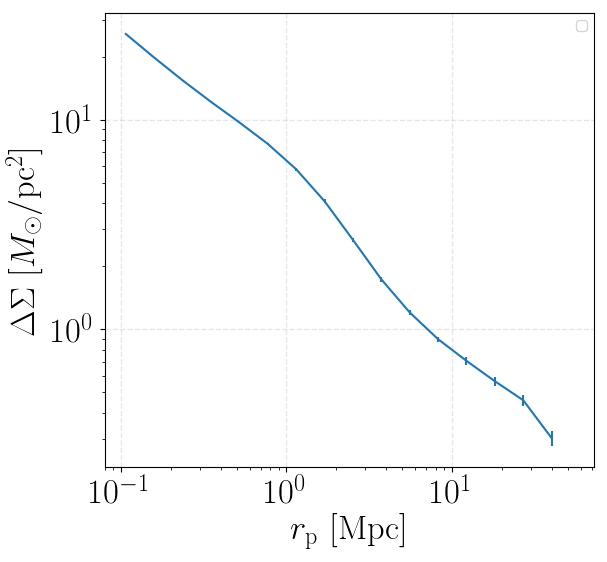

In [133]:
# Test

um_dsig_all = um_dsigma_jk(cfg_use, um_cubes, um_dsig)

um_dsig_avg = np.sum(um_dsig_all, axis=0) / (len(um_dsig_all) - 1)
um_dsig_err = np.sqrt(np.var(um_dsig_all, axis=0) * (len(um_dsig_all) - 1))

fig = plt.figure(figsize=(6, 5.5))

fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)

ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax.errorbar(um_rp_phy, um_dsig_avg, yerr=um_dsig_err)

ax.legend(fontsize=10, loc='upper right')

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8

ax.set_xlim(0.08, x_max)

_ = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
_ = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

### Split perpendicular to the Mmax-M10kpc relation

In [183]:
mh_low, mh_upp = 13.6, 13.8

# Mask for central galaxies
cen_mask = (um_cubes['upid'] == -1)

# Stellar mass limit
ms_mask = (um_cubes['logm_max'] >= 11.5)

# Mask for everything
mh_mask = ((um_cubes['logmh_vir'] >= mh_low) & 
           (um_cubes['logmh_vir'] <= mh_upp) & 
           ms_mask)

# Middle point
mtot_med, minn_med = np.nanmean(um_cubes[mh_mask]['logm_max']), np.nanmean(um_cubes[mh_mask]['logm_10'])

# Intercept of the Mmax-M10 relation
slope_a = 1.0
intercept_a = minn_med - slope_a * mtot_med
slope_b = -1.0 / slope_a
intercept_b = minn_med - slope_b * mtot_med

# Isolate the useful data
mtot_use = um_cubes[mh_mask]['logm_max']
minn_use = um_cubes[mh_mask]['logm_10']

halo_use = um_cubes[mh_mask]
dsig_use = um_dsig[mh_mask, :]

# Mask for central galaxies
cen_mask = halo_use['upid'] == -1

# Group galaxies based on their location on the Mmax-M10 plane
upp_mask = minn_use - (-1.0 * mtot_use + intercept_b) >= 0
low_mask = minn_use - (-1.0 * mtot_use + intercept_b) < 0

# Mean halo mass
upp_mhalo_mean = np.nanmedian(halo_use[upp_mask & cen_mask]['logmh_vir'])
low_mhalo_mean = np.nanmedian(halo_use[low_mask & cen_mask]['logmh_vir'])
print(upp_mhalo_mean, low_mhalo_mean)

# Get the weak lensing signals
um_rp_phy = np.logspace(np.log10(0.01), np.log10(40.0), 22)

# Just for the centrals
upp_dsig = um_dsigma_jk(cfg_use, halo_use[upp_mask & cen_mask], dsig_use[upp_mask & cen_mask, :])
low_dsig = um_dsigma_jk(cfg_use, halo_use[low_mask & cen_mask], dsig_use[low_mask & cen_mask, :])

upp_dsig_avg = np.sum(upp_dsig, axis=0) / (len(upp_dsig) - 1)
upp_dsig_err = np.sqrt(np.var(upp_dsig, axis=0) * (len(upp_dsig) - 1))

low_dsig_avg = np.sum(low_dsig, axis=0) / (len(low_dsig) - 1)
low_dsig_err = np.sqrt(np.var(low_dsig, axis=0) * (len(low_dsig) - 1))

# Just for the centrals
upp_dsig_2 = um_dsigma_jk(cfg_use, halo_use[upp_mask], dsig_use[upp_mask, :])
low_dsig_2 = um_dsigma_jk(cfg_use, halo_use[low_mask], dsig_use[low_mask, :])

upp_dsig_avg_2 = np.sum(upp_dsig_2, axis=0) / (len(upp_dsig_2) - 1)
upp_dsig_err_2 = np.sqrt(np.var(upp_dsig_2, axis=0) * (len(upp_dsig_2) - 1))

low_dsig_avg_2 = np.sum(low_dsig_2, axis=0) / (len(low_dsig_2) - 1)
low_dsig_err_2 = np.sqrt(np.var(low_dsig_2, axis=0) * (len(low_dsig_2) - 1))

(13.699837725867246, 13.689752687076638)
# There are 36 jackknife fields
# There are 36 jackknife fields
# There are 36 jackknife fields
# There are 36 jackknife fields


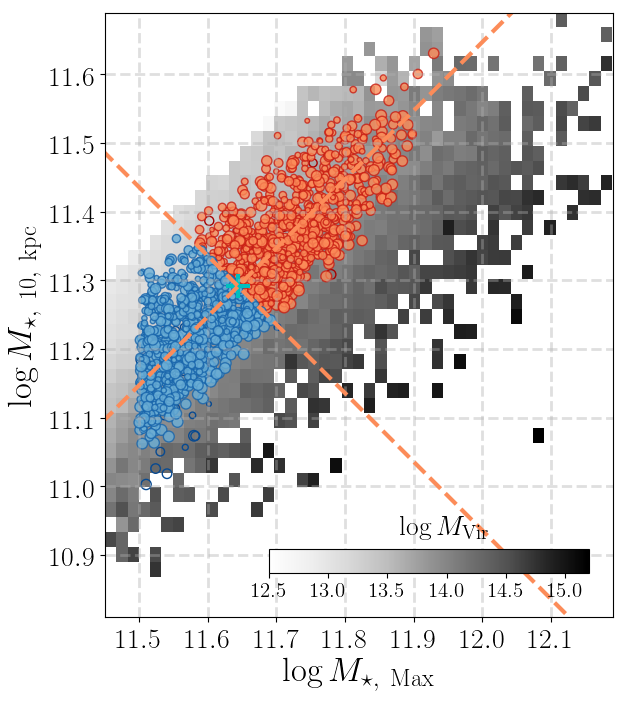

In [184]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

## Mmax-M10-Mvir trend
x_arr = logms_mod_tot[mask_mod]
y_arr = logms_mod_inn[mask_mod] + 0.02
z_arr = um_more['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, np.nanmedian, bins=(45, 45))

HM = ax1.imshow(z_stats.T, origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=12.5, vmax=15.20,
                aspect='auto', interpolation='nearest',
                cmap=BLK)

# Scatter plot for selected galaxies
# Upper: Satellite
ax1.scatter(mtot_use[upp_mask & ~cen_mask], 
            minn_use[upp_mask & ~cen_mask], 
            s=(halo_use['logmh_vir'][upp_mask & ~cen_mask] - mh_low + 0.04) * 260, 
            alpha=1.0, facecolor='none', edgecolor=ORG(0.9))

# Upper: Central
ax1.scatter(mtot_use[upp_mask & cen_mask], 
            minn_use[upp_mask & cen_mask], 
            s=(halo_use['logmh_vir'][upp_mask & cen_mask] - mh_low + 0.04) * 260, 
            alpha=0.8, facecolor=ORG(0.5), edgecolor=ORG(0.8))

# Lower: Satellites
ax1.scatter(mtot_use[low_mask & ~cen_mask], 
            minn_use[low_mask & ~cen_mask], 
            s=(halo_use['logmh_vir'][low_mask & ~cen_mask] - mh_low + 0.04) * 260, 
            alpha=1.0, facecolor='None', edgecolor=BLU(0.9))

# Lower: Central
ax1.scatter(mtot_use[low_mask & cen_mask], 
            minn_use[low_mask & cen_mask], 
            s=(halo_use['logmh_vir'][low_mask & cen_mask] - mh_low + 0.04) * 260, 
            alpha=0.8, facecolor=BLU(0.5), edgecolor=BLU(0.8))

# Plot the Mmax-M10 relation
mtot_arr = np.linspace(11.4, 12.2, 100)
ax1.plot(mtot_arr, slope_a * mtot_arr + intercept_a, 
         linestyle='--', linewidth=3.0, c=ORG(0.5))
ax1.plot(mtot_arr, slope_b * mtot_arr + intercept_b, 
         linestyle='--', linewidth=3.0, c=ORG(0.5))
ax1.scatter(mtot_med, minn_med, s=300, marker='+', c='c', linewidth=3.0)

# ax1.legend(fontsize=15, loc='upper left')

## Colorbar
cax = fig.add_axes([0.40, 0.18, 0.40, 0.03])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.58, 0.13, r'$\log M_{\rm Vir}$', transform=ax1.transAxes, size=20)
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

_ = ax1.set_xlim(11.45, 12.19)
_ = ax1.set_ylim(10.81, 11.69)
ax1.set_aspect('equal')

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=25)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=25)

# fig.savefig('fig/s16a_massive_logmmax_logm10_mhalo.pdf', dpi=150)

Text(0.5,0,'$r_{\\rm p}$ ${\\rm [Mpc]}$')

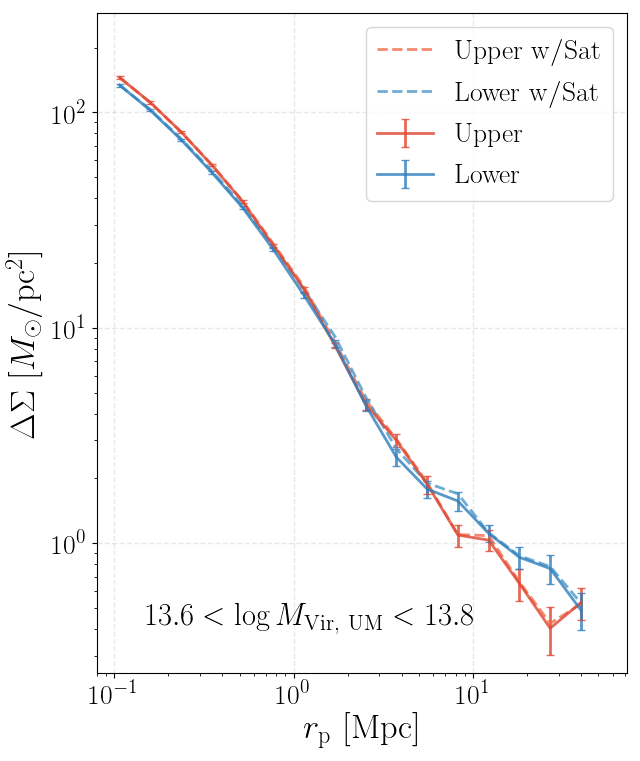

In [185]:
fig = plt.figure(figsize=(6.5, 8.0))
fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax = fig.add_subplot(111)
ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.errorbar(um_rp_phy, upp_dsig_avg, yerr=upp_dsig_err,
            linewidth=2.0, color=ORG(0.7), alpha=0.8,
            label=r'$\mathrm{Upper}$', capsize=3)

ax.plot(um_rp_phy, upp_dsig_avg_2,
        linewidth=2.0, color=ORG(0.6), alpha=0.8,
        label=r'$\mathrm{Upper\ w/Sat}$', linestyle='--')

ax.errorbar(um_rp_phy, low_dsig_avg, yerr=low_dsig_err,
            linewidth=2.0, color=BLU(0.7), alpha=0.8,
            label=r'$\mathrm{Lower}$', capsize=3)

ax.plot(um_rp_phy, low_dsig_avg_2,
        linewidth=2.0, color=BLU(0.6), alpha=0.8,
        label=r'$\mathrm{Lower\ w/Sat}$', linestyle='--')

ax.legend(fontsize=20, loc='upper right')

ax.text(0.15, 0.4, r'$%4.1f < \log M_{\rm Vir,\ UM} < %4.1f$' % (mh_low, mh_upp), 
        fontsize=22)

# X, Y Limits
x_min = np.min(um_rp_phy) * 0.2
x_max = np.max(um_rp_phy) * 1.8

ax.set_xlim(0.08, x_max)
ax.set_ylim(0.25, 290)

ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=25)
ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=25)

Text(0.5,0,'$\\log_{10}(r_{\\rm p}$ ${\\rm [Mpc]})$')

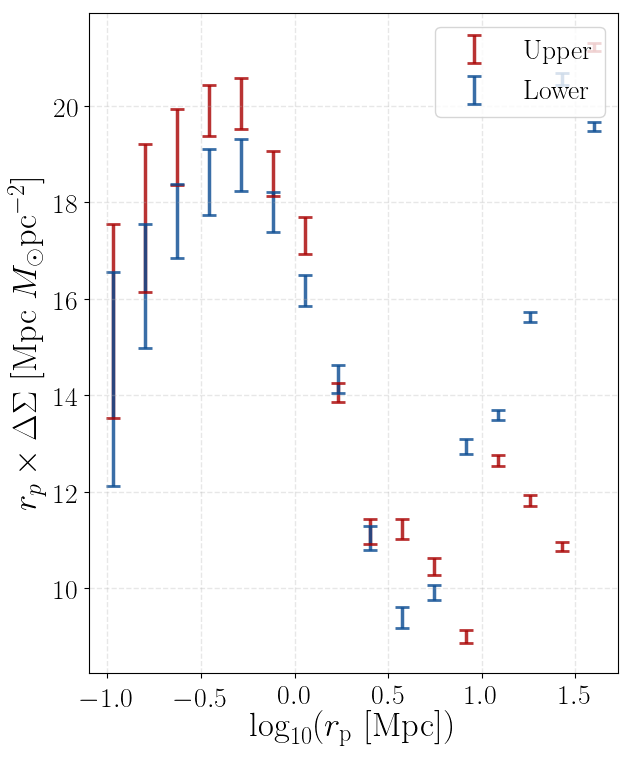

In [186]:
fig = plt.figure(figsize=(6.5, 8.0))
fig.subplots_adjust(left=0.18, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax = fig.add_subplot(111)
# ax.loglog()

ax.grid(linestyle='--', linewidth=1, alpha=0.3, zorder=0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.errorbar(np.log10(um_rp_phy), upp_dsig_avg * um_rp_phy, yerr=upp_dsig_err,
            fmt='o', ecolor=ORG(0.9), elinewidth=2.5, capsize=5, capthick=2.0,
            color=ORG(0.9), markersize=0, alpha=0.8,
            markeredgecolor='none', zorder=1,
            label=r'$\mathrm{Upper}$')

ax.errorbar(np.log10(um_rp_phy), low_dsig_avg * um_rp_phy, yerr=low_dsig_err,
            fmt='o', ecolor=BLU(0.9), elinewidth=2.5, capsize=5, capthick=2.0,
            color=BLU(0.9), markersize=0, alpha=0.8,
            markeredgecolor='none', zorder=1,
            label=r'$\mathrm{Lower}$')

ax.legend(fontsize=20, loc='upper right')

#ax.text(0.10, 1.0, r'$14.0 < \log M_{\rm Vir,\ UM} < 14.2$', fontsize=20)

# X, Y Limits
x_min = np.min(np.log10(um_rp_phy)) * 0.2
x_max = np.max(np.log10(um_rp_phy)) * 1.8

#ax.set_xlim(0.00, x_max)
#ax.set_ylim(y_min, y_max)

ax.set_ylabel(r'$r_{p} \times \Delta\Sigma$ $[\mathrm{Mpc}\ M_{\odot}{\rm pc}^{-2}]$', 
              fontsize=25)
ax.set_xlabel(r'$\log_{10}(r_{\rm p}$ ${\rm [Mpc]})$', fontsize=25)